In [7]:
%run ../../analysis_funcs.py

In [2]:
sb.set_style('darkgrid')

In [3]:
def convert_pvalue_to_asterisks(pvalue,ns = 'ns'):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ns

In [4]:
##Load parameters to check easily
with open("parameters.txt",'r') as fl:
    parameters = fl.readlines()

In [5]:
parameters

['N (number of taxa): 500\n',
 'M (number of samples): 150\n',
 'lam: 0.3 (LASSO parameter lambda for GLASSO)\n',
 'ch: 0 (chunkiness for NormalCowboy)\n',
 'ns: 2 (Number of simualted data types)\n',
 'gsp: 0.05 (approximate sparsity of ground truth)\n',
 'norms: add_pseudocounts (how count data is normalized by the method)\n',
 'grmod: PL (which graph model to base ground truth on)\n',
 'mean_spread: 4 (spread of log-means of absolute abundances)\n',
 'mean_center: 0 (center of uniform distrubition of log-means of absolute abundances)\n',
 'L (number of trials): 20\n',
 'mxvar: 2 (Max variance of absuolute abundances)\n',
 'mnvar: 0.3 (Min variance of absuolute abundances)\n',
 'hubcut (eigenvector centrality cutoff to consider a node a hub for comparison between networks): 0.3\n',
 'average read depth: 100000\n',
 'Standard deviation of read depth: 10000\n',
 'Use Correlation (instead of covariance): False\n',
 'Sparsity Structure Adjustment: None\n',
 'Block sign bias structure: [(

In [8]:
all_cov,splits = load_all_covariance()

In [9]:
actual_sparsity = pd.Series(index = all_cov.keys(),dtype = float)
for ky,val in all_cov.items():
    sp = ((val["Ground Truth"].round(8) != 0).sum() - 500)/(500**2-500)
    actual_sparsity.loc[ky] = sp
actual_sparsity

0     0.072160
1     0.072016
2     0.072120
3     0.072064
4     0.072281
5     0.072192
6     0.072321
7     0.072257
8     0.072289
9     0.072024
10    0.072224
11    0.072096
12    0.072168
13    0.072200
14    0.072104
15    0.072128
16    0.072048
17    0.072040
dtype: float64

In [13]:
coeff_dets = make_coeff_det_df(all_cov)
coeff_dets

,Log-Covariance,CLR-Mixed,CLR-Split,SparCC,GLASSO-Mixed,GLASSO-Split
0,0.020206,0.021729,0.008742,0.021698,0.015813,0.003932
1,0.047249,0.054643,0.045449,0.054601,0.062511,0.052907
2,0.018432,0.020053,0.007536,0.019979,0.016936,0.003909
3,0.019909,0.022618,0.008142,0.022591,0.018721,0.003848
4,0.023558,0.022591,0.009056,0.022547,0.016664,0.004350
5,0.047557,0.052656,0.039537,0.052686,0.069152,0.051643
6,0.024086,0.025888,0.011315,0.025861,0.020039,0.006633
7,0.015417,0.018995,0.006579,0.018982,0.014794,0.002863
8,0.012073,0.013872,0.007797,0.013746,0.007730,0.002795
9,0.016317,0.018329,0.007330,0.018309,0.013002,0.003221


In [14]:
significance_df = pd.DataFrame(index = coeff_dets.columns,columns = coeff_dets.columns)
for col in significance_df.columns:
    for rw in significance_df.index:
        if rw != col:
            significance_df.loc[rw,col] = stats.wilcoxon(coeff_dets[rw],coeff_dets[col]).pvalue

In [15]:
significance_df

,Log-Covariance,CLR-Mixed,CLR-Split,SparCC,GLASSO-Mixed,GLASSO-Split
Log-Covariance,NaN,0.001289,0.000008,0.001289,0.550873,0.000328
CLR-Mixed,0.001289,NaN,0.000008,0.141518,0.417114,0.000053
CLR-Split,0.000008,0.000008,NaN,0.000008,0.000015,0.417114
SparCC,0.001289,0.141518,0.000008,NaN,0.417114,0.000053
GLASSO-Mixed,0.550873,0.417114,0.000015,0.417114,NaN,0.000008
GLASSO-Split,0.000328,0.000053,0.417114,0.000053,0.000008,NaN


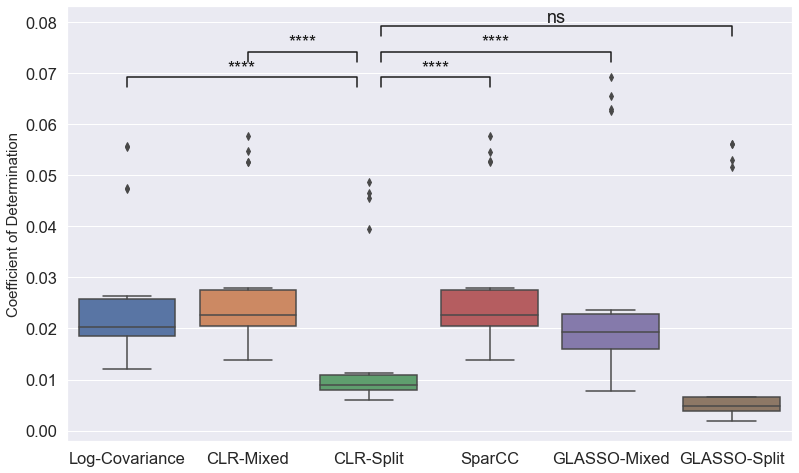

In [21]:
fig,ax = plt.subplots(figsize = (13,8))
sb.set(font_scale=1.5)

sb.boxplot(data = coeff_dets,ax=ax)
ax.set_ylabel("Coefficient of Determination",size=15)

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(coeff_dets.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = coeff_dets.values.max() - 0.005*(2-offset_dict[meth])+ 0.008, 0.002, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df.loc["CLR-Split",significance_df.columns[m]]
        plt.text((x1+x2)*.5, y+h+0.00, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)


In [ ]:
coeff_dets_XK = make_XK_coeff_det_df(all_cov,splits)

In [ ]:
significance_XK_df = pd.DataFrame(index = coeff_dets_XK.columns,columns = coeff_dets_XK.columns)
for col in significance_XK_df.columns:
    for rw in significance_XK_df.index:
        if rw != col:
            significance_XK_df.loc[rw,col] = stats.wilcoxon(coeff_dets_XK[rw],coeff_dets_XK[col]).pvalue

In [ ]:
significance_XK_df

In [ ]:
fig,ax = plt.subplots(figsize = (11,7))
sb.boxplot(data = coeff_dets_XK,ax=ax)
ax.set_ylabel("Coefficient of Determination",size=15)

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(coeff_dets_XK.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = coeff_dets_XK.values.max() - 0.01*(2-offset_dict[meth])+ 0.0055, 0.003, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_XK_df.loc["CLR-Split",significance_XK_df.columns[m]]
        plt.text((x1+x2)*.5, y+h+0.001, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [10]:
all_biases = pd.DataFrame(index = ["G1_{}_{}".format(k,nm) for k in all_cov.keys() for nm in all_cov[0].keys()] + ["G2_{}_{}".format(k,nm) for k in all_cov.keys() for nm in all_cov[0].keys()] + ["XK_{}_{}".format(k,nm) for k in all_cov.keys() for nm in all_cov[0].keys()],columns = ["Group","Mean Edge Weight","Reconstruction Method"])
all_pvals = pd.DataFrame(index = ["G1G2_{}_{}".format(k,nm) for k in all_cov.keys() for nm in all_cov[0].keys()] + ["G1XK_{}_{}".format(k,nm) for k in all_cov.keys() for nm in all_cov[0].keys()] + ["G2XK_{}_{}".format(k,nm) for k in all_cov.keys() for nm in all_cov[0].keys()],columns = ["Comparison","P-Value","Reconstruction Method"])
for k,val in all_cov.items():
    for nm,net in val.items():
        bias_dict,pval_dict = bias(net,splits.loc[k,0])
        all_biases.loc["G1_{}_{}".format(k,nm)] = ["Intra-Kingdom 1",bias_dict["G1_Mean"],nm]
        all_biases.loc["G2_{}_{}".format(k,nm)] = ["Intra-Kingdom 2",bias_dict["G2_Mean"],nm]
        all_biases.loc["XK_{}_{}".format(k,nm)] = ["Cross-Kingdom",bias_dict["XK_Mean"],nm]
        all_pvals.loc["G1G2_{}_{}".format(k,nm)] = ["G1G2",pval_dict["G1G2"],nm]
        all_pvals.loc["G1XK_{}_{}".format(k,nm)] = ["G1XK",pval_dict["G1XK"],nm]
        all_pvals.loc["G2XK_{}_{}".format(k,nm)] = ["G2XK",pval_dict["G2XK"],nm]

In [11]:
all_biases

,Group,Mean Edge Weight,Reconstruction Method
G1_0_Ground Truth,Intra-Kingdom 1,-0.000212,Ground Truth
G1_0_Absolute Emperical,Intra-Kingdom 1,0.000026,Absolute Emperical
G1_0_Log-Covariance,Intra-Kingdom 1,0.131146,Log-Covariance
G1_0_CLR-Mixed,Intra-Kingdom 1,0.066634,CLR-Mixed
G1_0_CLR-Split,Intra-Kingdom 1,-0.006185,CLR-Split
...,...,...,...
XK_17_CLR-Mixed,Cross-Kingdom,-0.066692,CLR-Mixed
XK_17_CLR-Split,Cross-Kingdom,0.0,CLR-Split
XK_17_SparCC,Cross-Kingdom,-0.064617,SparCC
XK_17_GLASSO-Mixed,Cross-Kingdom,-0.045434,GLASSO-Mixed


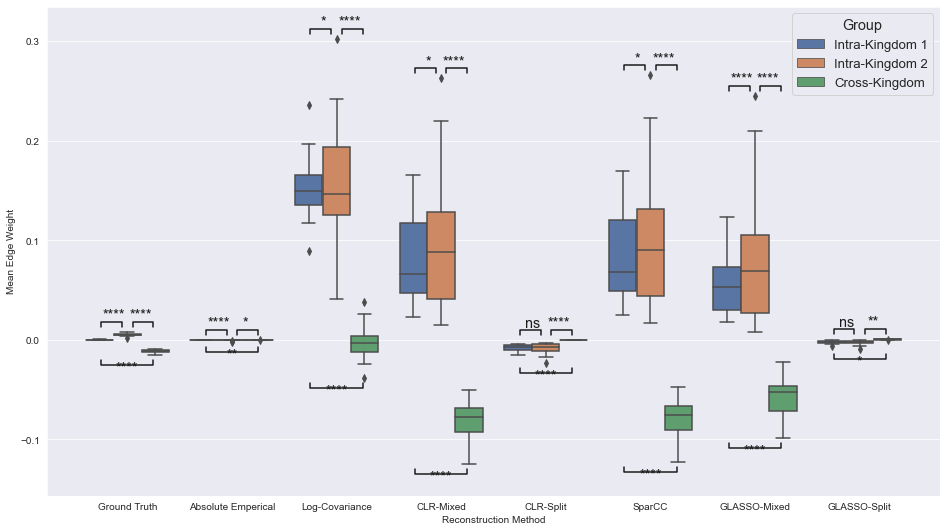

In [12]:
fig,ax = plt.subplots(figsize = (16,9))
sb.set(font_scale=1.2)
sb.boxplot(data = all_biases,x = "Reconstruction Method", y = "Mean Edge Weight", hue = "Group",ax = ax)

for i,m in enumerate(all_biases["Reconstruction Method"].unique()):
    subdf = all_biases[all_biases["Reconstruction Method"] == m]
    subpvaldf = all_pvals[all_pvals["Reconstruction Method"] == m]
    x1 = i-0.25
    x2 = i
    xxk = i+0.25
    h = 0.005
    y1 = subdf["Mean Edge Weight"].max() + h
    y2 = subdf["Mean Edge Weight"].min() - h
    col = 'k'
    
    plt.plot([x1, x1, x2-0.05, x2-0.05], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
    p = np.mean(subpvaldf[subpvaldf["Comparison"] == "G1G2"]["P-Value"])
    plt.text((x1+x2)*.5, y1+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col);
    
    plt.plot([x2+0.05, x2+0.05, xxk, xxk], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
    p = np.mean(subpvaldf[subpvaldf["Comparison"] == "G2XK"]["P-Value"])
    plt.text((x2+xxk)*.5, y1+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col);
    
    plt.plot([x1, x1, xxk, xxk], [y2, y2-h, y2-h, y2], lw=1.5, c=col)
    p = np.mean(subpvaldf[subpvaldf["Comparison"] == "G1XK"]["P-Value"])
    plt.text((x1+xxk)*.5, y2-3*h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col);

In [ ]:
topacc = all_top_accuracy(all_cov,100)

In [ ]:
test_net = "CLR-Split"
acc_significance_df = pd.DataFrame(index = topacc.index,columns = topacc.columns.unique())
for col in acc_significance_df.columns:
    for rw in acc_significance_df.index:
        if col != test_net:
            try:
                acc_significance_df.loc[rw,col] = stats.wilcoxon(topacc.loc[rw,test_net],topacc.loc[rw,col]).pvalue
            except ValueError:
                acc_significance_df.loc[rw,col] = 1

In [ ]:
offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":-1,"CLR-Mixed":-1,"SparCC":1,"GLASSO-Mixed":1,"GLASSO-Split":1}
methods_list = ["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]

longdf_topN = pd.DataFrame(columns = ["Number of Edges Considered (N)","Reconstruction Method","Proportion Correct"])
i = 0
for N in np.arange(10,101,10):
    for meth in topacc.columns.unique():
        vals = topacc.loc[N,meth]
        for j in range(len(vals)):
            longdf_topN.loc[i] = [N,meth,vals.iloc[j]]
            i+=1

            
fig,ax = plt.subplots(figsize = (16,9))
sb.set(font_scale=1.4)
sb.boxplot(data = longdf_topN,x = "Number of Edges Considered (N)", y = "Proportion Correct", hue = "Reconstruction Method",ax = ax)

for Ni,N in enumerate(longdf_topN["Number of Edges Considered (N)"].unique()):
    coords = np.linspace(Ni-0.33,Ni+0.33,6)
    x2 = coords[2]
    y1 = longdf_topN[longdf_topN["Number of Edges Considered (N)"] == N]["Proportion Correct"].max()+0.01
    for i,x1 in enumerate(coords):
        if i != 2:
            p = acc_significance_df.loc[N,acc_significance_df.columns[i]]
            if True:#p <= 0.05:
                meth = methods_list[i]
                y, h, col = y1 + 0.017*offset_dict[meth], 0.003, 'k'
                plt.plot([x1, x1, x2 + 0.02*x2_dict[meth], x2+ 0.02*x2_dict[meth]], [y, y+h, y+h, y], lw=1.5, c=col)
                plt.text((x1+x2)*.5, y-0.01, convert_pvalue_to_asterisks(p,ns=''), ha='center', va='bottom', color=col,size = 18);

In [ ]:
# fig,ax = plt.subplots(figsize = (15,10))
# sb.lineplot(data = topacc,ax = ax,linewidth=2)
# ax.set_ylabel("Proportion Correct",size=15)
# ax.set_xlabel("Number Of Edges Considered (N)",size=15)
# plt.legend(fontsize=15)

In [ ]:
topXKacc = all_top_XK_accuracy(all_cov,splits,100)

In [ ]:
test_net = "CLR-Split"
acc_significance_df_XK = pd.DataFrame(index = topXKacc.index,columns = topXKacc.columns.unique())
for col in acc_significance_df_XK.columns:
    for rw in acc_significance_df_XK.index:
        if col != test_net:
            try:
                acc_significance_df_XK.loc[rw,col] = stats.wilcoxon(topXKacc.loc[rw,test_net],topXKacc.loc[rw,col]).pvalue
            except ValueError:
                acc_significance_df_XK.loc[rw,col] = 1

In [ ]:
offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":-1,"CLR-Mixed":-1,"SparCC":1,"GLASSO-Mixed":1,"GLASSO-Split":1}
methods_list = ["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]

longdf_topN_XK = pd.DataFrame(columns = ["Number of Edges Considered (N)","Reconstruction Method","Proportion Correct"])
i = 0
for N in np.arange(10,101,10):
    for meth in topXKacc.columns.unique():
        vals = topXKacc.loc[N,meth]
        for j in range(len(vals)):
            longdf_topN_XK.loc[i] = [N,meth,vals.iloc[j]]
            i+=1

            
fig,ax = plt.subplots(figsize = (16,9))
sb.set(font_scale=1.4)
sb.boxplot(data = longdf_topN_XK,x = "Number of Edges Considered (N)", y = "Proportion Correct", hue = "Reconstruction Method",ax = ax)

for Ni,N in enumerate(longdf_topN_XK["Number of Edges Considered (N)"].unique()):
    coords = np.linspace(Ni-0.33,Ni+0.33,6)
    x2 = coords[2]
    y1 = longdf_topN_XK[longdf_topN_XK["Number of Edges Considered (N)"] == N]["Proportion Correct"].max()+0.01
    for i,x1 in enumerate(coords):
        if i != 2:
            p = acc_significance_df_XK.loc[N,acc_significance_df_XK.columns[i]]
            if True:#p <= 0.05:
                meth = methods_list[i]
                y, h, col = y1 + 0.02*offset_dict[meth], 0.003, 'k'
                plt.plot([x1, x1, x2 + 0.02*x2_dict[meth], x2+ 0.02*x2_dict[meth]], [y, y+h, y+h, y], lw=1.5, c=col)
                plt.text((x1+x2)*.5, y-0.015, convert_pvalue_to_asterisks(p,ns=''), ha='center', va='bottom', color=col,size = 18);

In [ ]:
# fig,ax = plt.subplots(figsize = (15,10))
# sb.lineplot(data = topXKacc,ax = ax,linewidth=2)
# ax.set_ylabel("Proportion Correct",size=15)
# ax.set_xlabel("Number Of Cross-Kingdom Edges Considered (N)",size=15)
# plt.legend(fontsize=15)

In [ ]:
roc_all_edges = all_classifier_performance_topN(all_cov,-1)

In [ ]:
significance_df_edge_roc = pd.DataFrame(index = roc_all_edges[0].columns,columns = roc_all_edges[0].columns)
for col in significance_df_edge_roc.columns:
    for rw in significance_df_edge_roc.index:
        if rw != col:
            significance_df_edge_roc.loc[rw,col] = stats.wilcoxon(roc_all_edges[0][rw],roc_all_edges[0][col]).pvalue


In [ ]:
fig,ax = plt.subplots(figsize = (15,10))
sb.boxplot(data = roc_all_edges[0],ax=ax)
ax.set_ylabel("AUC-ROC of Unsigned Edge Detection",size=15)

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(roc_all_edges[0].columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = roc_all_edges[0].values.max() + 0.007*(offset_dict[meth])+ 0.001, 0.003, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_edge_roc.loc["CLR-Split",significance_df_edge_roc.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)


In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
base_fpr = np.linspace(0, 1, 100)

for n,meth in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    
    ax[divmod(n,3)].plot([0,1],[0,1],':',color = 'red')
    tprs = []
    for tr in roc_all_edges[1][meth]:
        ax[divmod(n,3)].plot(tr[0],tr[1],color = 'blue',alpha = 0.4)
        tpr = np.interp(base_fpr, tr[0], tr[1])
        tpr[0] = 0.0
        tprs.append(tpr)
    ax[divmod(n,3)].plot(base_fpr,np.array(tprs).mean(axis = 0),color = 'blue')
    tprs_lower = np.maximum(np.array(tprs).mean(axis = 0) - np.array(tprs).std(axis = 0),0)
    tprs_upper = np.minimum(np.array(tprs).mean(axis = 0) + np.array(tprs).std(axis = 0),1)

    ax[divmod(n,3)].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    ax[divmod(n,3)].set_xlabel("False Positive Rate")
    ax[divmod(n,3)].set_ylabel("True Positive Rate")
    ax[divmod(n,3)].set_title(meth)

In [ ]:
roc_top_edges = all_classifier_performance(all_cov,Ns = np.arange(100,9000,400))

In [ ]:
longdf_roc_topN = pd.DataFrame(columns = ["Number of True Edges Considered","Reconstruction Method","Area Under ROC-Curve"])
i = 0
for rw in np.arange(0,23,4):
    tm = roc_top_edges.index[rw]
    for meth in roc_top_edges.columns.unique():
        vals = roc_top_edges.loc[tm,meth]
        for j in range(len(vals)):
            longdf_roc_topN.loc[i] = [tm,meth,vals.iloc[j]]
            i+=1

In [ ]:
test_net = "CLR-Split"
significance_df_topN_byN = pd.DataFrame(index = roc_top_edges.index,columns = roc_top_edges.columns.unique())
for col in significance_df_topN_byN.columns:
    for rw in significance_df_topN_byN.index:
        if test_net != col:
            significance_df_topN_byN.loc[rw,col] = stats.wilcoxon(roc_top_edges.loc[rw,test_net],roc_top_edges.loc[rw,col]).pvalue


In [ ]:

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":-1,"CLR-Mixed":-1,"SparCC":1,"GLASSO-Mixed":1,"GLASSO-Split":1}
methods_list = ["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]

            
fig,ax = plt.subplots(figsize = (16,10))
sb.set(font_scale=1.4)
sb.boxplot(data = longdf_roc_topN,x = "Number of True Edges Considered", y = "Area Under ROC-Curve", hue = "Reconstruction Method",ax = ax)

for Ni,N in enumerate(longdf_roc_topN["Number of True Edges Considered"].unique()):
    coords = np.linspace(Ni-0.33,Ni+0.33,6)
    x2 = coords[2]
    y1 = longdf_roc_topN[longdf_roc_topN["Number of True Edges Considered"] == N]["Area Under ROC-Curve"].max()+0.01
    for i,x1 in enumerate(coords):
        if i != 2:
            p = significance_df_topN_byN.loc[N,significance_df_topN_byN.columns[i]]
            if True:#p <= 0.05:
                meth = methods_list[i]
                y, h, col = y1 + 0.015*offset_dict[meth], 0.003, 'k'
                plt.plot([x1, x1, x2 + 0.02*x2_dict[meth], x2+ 0.02*x2_dict[meth]], [y, y+h, y+h, y], lw=1.5, c=col)
                plt.text((x1+x2)*.5, y-0.003, convert_pvalue_to_asterisks(p,ns=''), ha='center', va='bottom', color=col);


In [ ]:
# fig,ax = plt.subplots(figsize = (15,10))
# sb.lineplot(data = roc_top_edges,ax = ax,linewidth=3)
# ax.set_ylabel("Area Under ROC-Curve",size=15)
# ax.set_xlabel("Number Of True Edges Considered",size=15)
# plt.legend(fontsize=15)

In [ ]:
XK_roc_all_edges = all_XK_classifier_performance_topN(all_cov,splits,-1)

In [ ]:
significance_df_edge_roc_XK = pd.DataFrame(index = XK_roc_all_edges[0].columns,columns = XK_roc_all_edges[0].columns)
for col in significance_df_edge_roc_XK.columns:
    for rw in significance_df_edge_roc_XK.index:
        if rw != col:
            significance_df_edge_roc_XK.loc[rw,col] = stats.wilcoxon(XK_roc_all_edges[0][rw],XK_roc_all_edges[0][col]).pvalue


In [ ]:
fig,ax = plt.subplots(figsize = (15,10))
sb.boxplot(data = XK_roc_all_edges[0],ax=ax)
ax.set_ylabel("AUC-ROC of Unsigned Edge Detection",size=15)

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(XK_roc_all_edges[0].columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = XK_roc_all_edges[0].values.max() + 0.007*(offset_dict[meth])+ 0.001, 0.003, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_edge_roc_XK.loc["CLR-Split",significance_df_edge_roc_XK.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col);

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
base_fpr = np.linspace(0, 1, 100)

for n,meth in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    
    ax[divmod(n,3)].plot([0,1],[0,1],':',color = 'red')
    tprs = []
    for tr in XK_roc_all_edges[1][meth]:
        ax[divmod(n,3)].plot(tr[0],tr[1],color = 'blue',alpha = 0.4)
        tpr = np.interp(base_fpr, tr[0], tr[1])
        tpr[0] = 0.0
        tprs.append(tpr)
    ax[divmod(n,3)].plot(base_fpr,np.array(tprs).mean(axis = 0),color = 'blue')
    tprs_lower = np.maximum(np.array(tprs).mean(axis = 0) - np.array(tprs).std(axis = 0),0)
    tprs_upper = np.minimum(np.array(tprs).mean(axis = 0) + np.array(tprs).std(axis = 0),1)

    ax[divmod(n,3)].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    ax[divmod(n,3)].set_xlabel("False Positive Rate")
    ax[divmod(n,3)].set_ylabel("True Positive Rate")
    ax[divmod(n,3)].set_title(meth)

In [ ]:
XK_roc_top_edges = all_XK_classifier_performance(all_cov,splits,Ns = np.arange(50,3950,100))

In [ ]:
longdf_roc_XK = pd.DataFrame(columns = ["Number of True Edges Considered","Reconstruction Method","Area Under ROC-Curve"])
i = 0
for rw in np.arange(0,23,4):
    tm = XK_roc_top_edges.index[rw]
    for meth in XK_roc_top_edges.columns.unique():
        vals = XK_roc_top_edges.loc[tm,meth]
        for j in range(len(vals)):
            longdf_roc_XK.loc[i] = [tm,meth,vals.iloc[j]]
            i+=1

In [ ]:
test_net = "CLR-Split"
significance_df_topN_byN_XK = pd.DataFrame(index = XK_roc_top_edges.index,columns = XK_roc_top_edges.columns.unique())
for col in significance_df_topN_byN_XK.columns:
    for rw in significance_df_topN_byN_XK.index:
        if test_net != col:
            significance_df_topN_byN_XK.loc[rw,col] = stats.wilcoxon(XK_roc_top_edges.loc[rw,test_net],XK_roc_top_edges.loc[rw,col]).pvalue

In [ ]:
offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":-1,"CLR-Mixed":-1,"SparCC":1,"GLASSO-Mixed":1,"GLASSO-Split":1}
methods_list = ["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]

            
fig,ax = plt.subplots(figsize = (16,10))
sb.set(font_scale=1.4)
sb.boxplot(data = longdf_roc_XK,x = "Number of True Edges Considered", y = "Area Under ROC-Curve", hue = "Reconstruction Method",ax = ax)

for Ni,N in enumerate(longdf_roc_XK["Number of True Edges Considered"].unique()):
    coords = np.linspace(Ni-0.33,Ni+0.33,6)
    x2 = coords[2]
    y1 = longdf_roc_XK[longdf_roc_XK["Number of True Edges Considered"] == N]["Area Under ROC-Curve"].max()+0.01
    for i,x1 in enumerate(coords):
        if i != 2:
            p = significance_df_topN_byN_XK.loc[N,significance_df_topN_byN_XK.columns[i]]
            if True:#p <= 0.05:
                meth = methods_list[i]
                y, h, col = y1 + 0.012*offset_dict[meth], 0.003, 'k'
                plt.plot([x1, x1, x2 + 0.02*x2_dict[meth], x2+ 0.02*x2_dict[meth]], [y, y+h, y+h, y], lw=1.5, c=col)
                plt.text((x1+x2)*.5, y-0.003, convert_pvalue_to_asterisks(p,ns=''), ha='center', va='bottom', color=col);

        

In [ ]:
XK_roc_500_edges = all_XK_classifier_performance_topN(all_cov,splits,500)
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
base_fpr = np.linspace(0, 1, 100)

for n,meth in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    
    ax[divmod(n,3)].plot([0,1],[0,1],':',color = 'red')
    tprs = []
    for tr in XK_roc_500_edges[1][meth]:
        ax[divmod(n,3)].plot(tr[0],tr[1],color = 'blue',alpha = 0.4)
        tpr = np.interp(base_fpr, tr[0], tr[1])
        tpr[0] = 0.0
        tprs.append(tpr)
    ax[divmod(n,3)].plot(base_fpr,np.array(tprs).mean(axis = 0),color = 'blue')
    tprs_lower = np.maximum(np.array(tprs).mean(axis = 0) - np.array(tprs).std(axis = 0),0)
    tprs_upper = np.minimum(np.array(tprs).mean(axis = 0) + np.array(tprs).std(axis = 0),1)

    ax[divmod(n,3)].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    ax[divmod(n,3)].set_xlabel("False Positive Rate")
    ax[divmod(n,3)].set_ylabel("True Positive Rate")
    ax[divmod(n,3)].set_title(meth)

In [ ]:
roc_all_hubs = all_hub_performance_topN(all_cov,N=-1,hubct = 0.5,posnet = True)

In [ ]:
significance_df_hubroc = pd.DataFrame(index = roc_all_hubs[0].columns,columns = roc_all_hubs[0].columns)
for col in significance_df_hubroc.columns:
    for rw in significance_df_hubroc.index:
        if rw != col:
            significance_df_hubroc.loc[rw,col] = stats.wilcoxon(roc_all_hubs[0][rw],roc_all_hubs[0][col]).pvalue
            
fig,ax = plt.subplots(figsize = (15,10))
sb.boxplot(data = roc_all_hubs[0],ax=ax)
ax.set_ylabel("AUC-ROC of Hub Detection",size = 12);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(roc_all_hubs[0].columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = roc_all_hubs[0].values.max() - 0.025*(2-offset_dict[meth])+ 0.06, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_hubroc.loc["CLR-Split",significance_df_hubroc.columns[m]]
        plt.text((x1+x2)*.5, y+h-0.005, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
base_fpr = np.linspace(0, 1, 100)

for n,meth in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    
    ax[divmod(n,3)].plot([0,1],[0,1],':',color = 'red')
    tprs = []
    for tr in roc_all_hubs[1][meth]:
        ax[divmod(n,3)].plot(tr[0],tr[1],color = 'blue',alpha = 0.4)
        tpr = np.interp(base_fpr, tr[0], tr[1])
        tpr[0] = 0.0
        tprs.append(tpr)
    ax[divmod(n,3)].plot(base_fpr,np.array(tprs).mean(axis = 0),color = 'blue')
    tprs_lower = np.maximum(np.array(tprs).mean(axis = 0) - np.array(tprs).std(axis = 0),0)
    tprs_upper = np.minimum(np.array(tprs).mean(axis = 0) + np.array(tprs).std(axis = 0),1)

    ax[divmod(n,3)].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    ax[divmod(n,3)].set_xlabel("False Positive Rate")
    ax[divmod(n,3)].set_ylabel("True Positive Rate")
    ax[divmod(n,3)].set_title(meth)

In [ ]:
roc_top_hubs_val = all_hub_performance_byval(all_cov,cuts = np.linspace(0.1,0.99,21))
roc_top_hubs_val;

In [ ]:
test_net = "CLR-Split"
hub_roc_top_val_significance = pd.DataFrame(index = roc_top_hubs_val.index,columns = roc_top_hubs_val.columns.unique())
for col in hub_roc_top_val_significance.columns:
    for rw in hub_roc_top_val_significance.index:
        if col != test_net:
            try:
                hub_roc_top_val_significance.loc[rw,col] = stats.wilcoxon(roc_top_hubs_val.loc[rw,test_net],roc_top_hubs_val.loc[rw,col]).pvalue
            except ValueError:
                hub_roc_top_val_significance.loc[rw,col] = 1

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":-1,"CLR-Mixed":-1,"SparCC":1,"GLASSO-Mixed":1,"GLASSO-Split":1}
methods_list = ["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]

longdf_hubroc_byval = pd.DataFrame(columns = ["Centraility Cutoff for True Hubs","Reconstruction Method","Area Under ROC-Curve"])
i = 0
for N in roc_top_hubs_val.index[np.arange(0,21,5)]:
    for meth in roc_top_hubs_val.columns.unique():
        vals = roc_top_hubs_val.loc[N,meth]
        for j in range(len(vals)):
            longdf_hubroc_byval.loc[i] = [N,meth,vals.iloc[j]]
            i+=1

            
fig,ax = plt.subplots(figsize = (16,9))
sb.set(font_scale=1.2)
sb.boxplot(data = longdf_hubroc_byval,x = "Centraility Cutoff for True Hubs", y = "Area Under ROC-Curve", hue = "Reconstruction Method",ax = ax)

for Ni,N in enumerate(longdf_hubroc_byval["Centraility Cutoff for True Hubs"].unique()):
    coords = np.linspace(Ni-0.33,Ni+0.33,6)
    x2 = coords[2]
    y1 = longdf_hubroc_byval[longdf_hubroc_byval["Centraility Cutoff for True Hubs"] == N]["Area Under ROC-Curve"].max() + 0.003
    for i,x1 in enumerate(coords):
        if i != 2:
            p = hub_roc_top_val_significance.loc[N,hub_roc_top_val_significance.columns[i]]
            if True:#p <= 0.05:
                meth = methods_list[i]
                y, h, col = y1 + 0.01*offset_dict[meth], 0.003, 'k'
                plt.plot([x1, x1, x2 + 0.02*x2_dict[meth], x2+ 0.02*x2_dict[meth]], [y, y+h, y+h, y], lw=1.5, c=col)
                plt.text((x1+x2)*.5, y, convert_pvalue_to_asterisks(p,ns=''), ha='center', va='bottom', color=col);

In [ ]:
roc_top_hubs_N = all_hub_performance_byN(all_cov,Ns = np.arange(5,110,5))
roc_top_hubs_N;

In [ ]:
roc_top_hubs_N.index[np.arange(0,21,5)]

In [ ]:
test_net = "CLR-Split"
hub_roc_top_N_significance = pd.DataFrame(index = roc_top_hubs_N.index,columns = roc_top_hubs_N.columns.unique())
for col in hub_roc_top_N_significance.columns:
    for rw in hub_roc_top_N_significance.index:
        if col != test_net:
            try:
                hub_roc_top_N_significance.loc[rw,col] = stats.wilcoxon(roc_top_hubs_N.loc[rw,test_net],roc_top_hubs_N.loc[rw,col]).pvalue
            except ValueError:
                hub_roc_top_N_significance.loc[rw,col] = 1

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":-1,"CLR-Mixed":-1,"SparCC":1,"GLASSO-Mixed":1,"GLASSO-Split":1}
methods_list = ["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]

longdf_hubroc_byN = pd.DataFrame(columns = ["Number of Nodes Considered True Hubs","Reconstruction Method","Area Under ROC-Curve"])
i = 0
for N in roc_top_hubs_N.index[np.arange(0,21,5)]:
    for meth in roc_top_hubs_N.columns.unique():
        vals = roc_top_hubs_N.loc[N,meth]
        for j in range(len(vals)):
            longdf_hubroc_byN.loc[i] = [N,meth,vals.iloc[j]]
            i+=1

            
fig,ax = plt.subplots(figsize = (16,9))
sb.set(font_scale=1.2)
sb.boxplot(data = longdf_hubroc_byN,x = "Number of Nodes Considered True Hubs", y = "Area Under ROC-Curve", hue = "Reconstruction Method",ax = ax)

for Ni,N in enumerate(longdf_hubroc_byN["Number of Nodes Considered True Hubs"].unique()):
    coords = np.linspace(Ni-0.33,Ni+0.33,6)
    x2 = coords[2]
    y1 = longdf_hubroc_byN[longdf_hubroc_byN["Number of Nodes Considered True Hubs"] == N]["Area Under ROC-Curve"].max() + 0.003
    for i,x1 in enumerate(coords):
        if i != 2:
            p = hub_roc_top_N_significance.loc[N,hub_roc_top_N_significance.columns[i]]
            if True:#p <= 0.05:
                meth = methods_list[i]
                y, h, col = y1 + 0.01*offset_dict[meth], 0.003, 'k'
                plt.plot([x1, x1, x2 + 0.02*x2_dict[meth], x2+ 0.02*x2_dict[meth]], [y, y+h, y+h, y], lw=1.5, c=col)
                plt.text((x1+x2)*.5, y, convert_pvalue_to_asterisks(p,ns=''), ha='center', va='bottom', color=col);

In [18]:
tr = 0

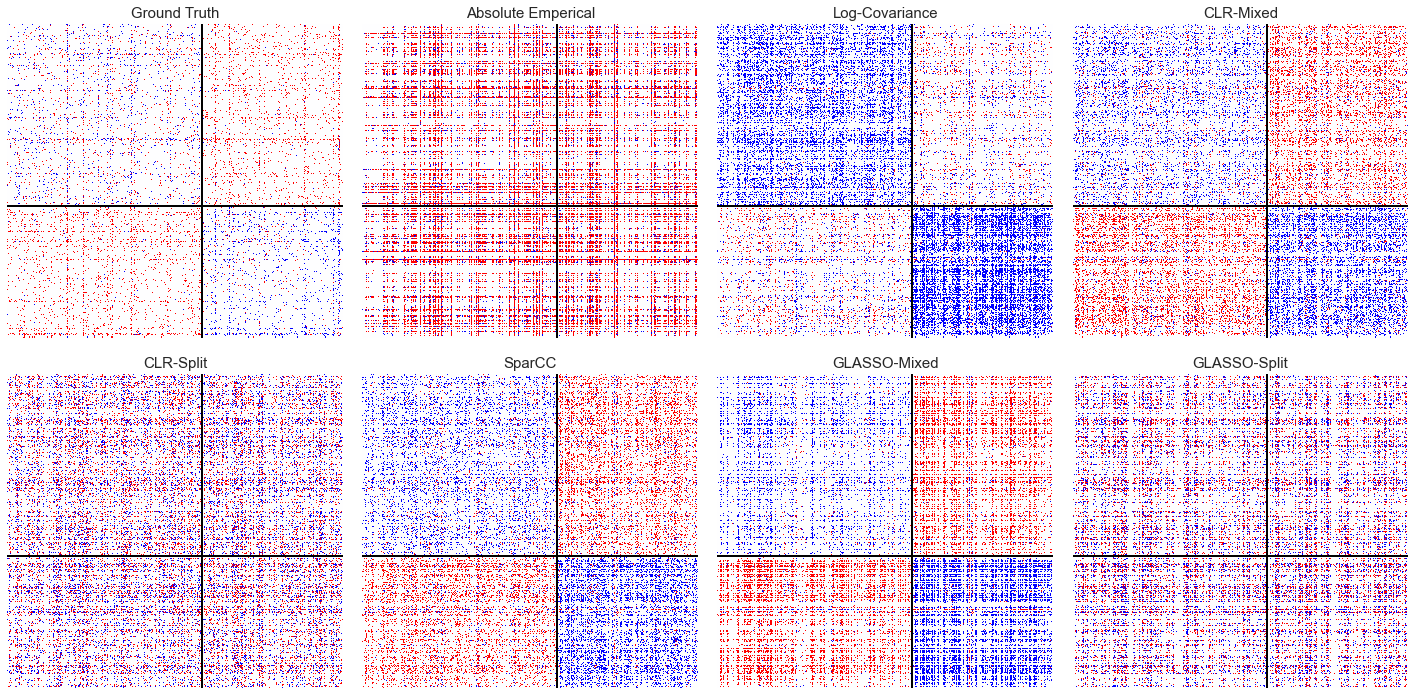

In [19]:
fig,ax = plt.subplots(2,4,figsize = (20,10),tight_layout = True)

for n,meth in enumerate(all_cov[tr].keys()):
    ax[divmod(n,4)].xaxis.set_tick_params(labelbottom=False)
    ax[divmod(n,4)].yaxis.set_tick_params(labelleft=False)

    sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax[divmod(n,4)])
    ax[divmod(n,4)].plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=2)
    ax[divmod(n,4)].plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=2)

    ax[divmod(n,4)].set_xticks([])
    ax[divmod(n,4)].set_yticks([])
    ax[divmod(n,4)].set_title(meth,fontsize=15)



In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)

meth = "Ground Truth"

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.0),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([]);

In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)

meth = 'Absolute Emperical'

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)

meth ='Log-Covariance'

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)


meth = 'CLR-Mixed'

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)

meth = 'CLR-Split'

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)

meth ='SparCC'

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)

meth = 'GLASSO-Mixed'

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(figsize = (10,10),tight_layout = True)

meth = 'GLASSO-Split'

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

sb.heatmap(topQnet(all_cov[tr][meth].round(8),q=0.9),cmap = "bwr_r",cbar = False,ax = ax)
ax.plot([0,500],[splits.loc[tr,0],splits.loc[tr,0]],color='black',linewidth=3)
ax.plot([splits.loc[tr,0],splits.loc[tr,0]],[0,500],color='black',linewidth=3)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
edge_df = make_edge_df(all_cov[tr])
fig.suptitle("Scatterplots of True Edge Values vs. Fit Edge Values with Regression Line",size=18)
for n,col in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    sb.scatterplot(data=edge_df.round(15), x="Ground Truth", y=col,ax = ax[divmod(n,3)])
    x = np.linspace(-0.9,2,1000)
    m,b = np.polyfit(edge_df["Ground Truth"],edge_df[col],1,full = False)
    ax[divmod(n,3)].plot(x,m*x+b,color = 'y',linewidth = 2)

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
edge_df = make_XK_edge_df(all_cov[tr],splits.loc[tr,0])
fig.suptitle("Scatterplots of True Cross-Kingdom Edge Values vs. Fit Cross-Kingdom Edge Values with Regression Line",size=18)
for n,col in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    sb.scatterplot(data=edge_df.round(15), x="Ground Truth", y=col,ax = ax[divmod(n,3)])
    x = np.linspace(-0.9,2,1000)
    m,b = np.polyfit(edge_df["Ground Truth"],edge_df[col],1,full = False)
    ax[divmod(n,3)].plot(x,m*x+b,color = 'y',linewidth = 2)

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
edge_df = make_edge_df(all_cov[tr])
edge_df["Correct Edge Sign"] = edge_df["Ground Truth"].round(8).apply(np.sign)
for n,col in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    sb.histplot(data=edge_df.round(15), x=col, hue="Correct Edge Sign",ax = ax[divmod(n,3)],kde = True,palette = "bwr_r")
    ax[divmod(n,3)].plot([0,0],[0,100],linewidth = 2,color = 'k')
    ax[divmod(n,3)].set_ybound(0,100)

In [ ]:
betweenness_all_trials,degree_all_trials,eigen_all_trials = compare_centrality_alltrials(all_cov,degree_cutoff_q = 0.9)

In [ ]:
significance_df_betweenness = pd.DataFrame(index = betweenness_all_trials.index,columns = betweenness_all_trials.index)
for col in significance_df_betweenness.columns:
    for rw in significance_df_betweenness.index:
        if rw != col:
            significance_df_betweenness.loc[rw,col] = stats.wilcoxon(betweenness_all_trials.loc[rw],betweenness_all_trials.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = betweenness_all_trials.T,ax = ax)
ax.set_ylabel("Coefficient of Determination (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(betweenness_all_trials.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = betweenness_all_trials.T.values.max() - 0.02*(2-offset_dict[meth])+0.015, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_betweenness.loc["CLR-Split",significance_df_betweenness.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)



In [ ]:
significance_df_degree = pd.DataFrame(index = degree_all_trials.index,columns = degree_all_trials.index)
for col in significance_df_degree.columns:
    for rw in significance_df_degree.index:
        if rw != col:
            significance_df_degree.loc[rw,col] = stats.wilcoxon(degree_all_trials.loc[rw],degree_all_trials.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = degree_all_trials.T,ax = ax)
ax.set_ylabel("Coefficient of Determination (Degree Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(degree_all_trials.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = degree_all_trials.T.values.max() - 0.003*(2-offset_dict[meth])+0.005, 0.002, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_degree.loc["CLR-Split",significance_df_degree.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
significance_df_eigen = pd.DataFrame(index = eigen_all_trials.index,columns = eigen_all_trials.index)
for col in significance_df_eigen.columns:
    for rw in significance_df_eigen.index:
        if rw != col:
            significance_df_eigen.loc[rw,col] = stats.wilcoxon(eigen_all_trials.loc[rw],eigen_all_trials.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = eigen_all_trials.T,ax = ax)
ax.set_ylabel("Coefficient of Determination (Eigenvector Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(eigen_all_trials.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = eigen_all_trials.T.values.max() - 0.025*(2-offset_dict[meth])+0.035, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_eigen.loc["CLR-Split",significance_df_eigen.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)


In [ ]:
betweenness_all_trials_abs,degree_all_trials_abs,eigen_all_trials_abs = compare_centrality_alltrials(all_cov,posnet = False,degree_cutoff_q = 0.9)

In [ ]:
significance_df_betweenness_abs = pd.DataFrame(index = betweenness_all_trials_abs.index,columns = betweenness_all_trials_abs.index)
for col in significance_df_betweenness_abs.columns:
    for rw in significance_df_betweenness_abs.index:
        if rw != col:
            significance_df_betweenness_abs.loc[rw,col] = stats.wilcoxon(betweenness_all_trials_abs.loc[rw],betweenness_all_trials_abs.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = betweenness_all_trials_abs.T,ax = ax)
ax.set_ylabel("Coefficient of Determination (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(betweenness_all_trials_abs.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = betweenness_all_trials_abs.T.values.max() - 0.025*(2-offset_dict[meth])+0.01, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_betweenness_abs.loc["CLR-Split",significance_df_betweenness_abs.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
significance_df_degree_abs = pd.DataFrame(index = degree_all_trials_abs.index,columns = degree_all_trials_abs.index)
for col in significance_df_degree_abs.columns:
    for rw in significance_df_degree_abs.index:
        if rw != col:
            try:
                significance_df_degree_abs.loc[rw,col] = stats.wilcoxon(degree_all_trials_abs.loc[rw],degree_all_trials_abs.loc[col]).pvalue
            except:
                significance_df_degree_abs.loc[rw,col] = 1
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = degree_all_trials_abs.T,ax = ax)
ax.set_ylabel("Coefficient of Determination (Degree Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(degree_all_trials_abs.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = degree_all_trials_abs.T.values.max() - 0.003*(2-offset_dict[meth])+0.005, 0.002, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_degree_abs.loc["CLR-Split",significance_df_degree_abs.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
significance_df_eigen_abs = pd.DataFrame(index = eigen_all_trials_abs.index,columns = eigen_all_trials_abs.index)
for col in significance_df_eigen_abs.columns:
    for rw in significance_df_eigen_abs.index:
        if rw != col:
            significance_df_eigen_abs.loc[rw,col] = stats.wilcoxon(eigen_all_trials_abs.loc[rw],eigen_all_trials_abs.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = eigen_all_trials_abs.T,ax = ax)
ax.set_ylabel("Coefficient of Determination (Eigenvector Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(eigen_all_trials_abs.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = eigen_all_trials_abs.T.values.max() - 0.025*(2-offset_dict[meth])+0.05, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_eigen_abs.loc["CLR-Split",significance_df_eigen_abs.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
betweenness_roc,degree_roc,eigen_roc,centrality_roc_curves = centrality_ROC_alltrials(all_cov,posnet = True,degree_cutoff_q = 0.9)

In [ ]:
significance_df_betweenness_roc = pd.DataFrame(index = betweenness_roc.index,columns = betweenness_roc.index)
for col in significance_df_betweenness_roc.columns:
    for rw in significance_df_betweenness_roc.index:
        if rw != col:
            significance_df_betweenness_roc.loc[rw,col] = stats.wilcoxon(betweenness_roc.loc[rw],betweenness_roc.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = betweenness_roc.T,ax = ax)
ax.set_ylabel("AUC-ROC (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(betweenness_roc.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = betweenness_roc.T.values.max() - 0.025*(2-offset_dict[meth])+0.01, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_betweenness_roc.loc["CLR-Split",significance_df_betweenness_roc.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
significance_df_degree_roc = pd.DataFrame(index = degree_roc.index,columns = degree_roc.index)
for col in significance_df_degree_roc.columns:
    for rw in significance_df_degree_roc.index:
        if rw != col:
            significance_df_degree_roc.loc[rw,col] = stats.wilcoxon(degree_roc.loc[rw],degree_roc.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = degree_roc.T,ax = ax)
ax.set_ylabel("AUC-ROC (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(degree_roc.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = degree_roc.T.values.max() - 0.025*(2-offset_dict[meth])+0.01, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_degree_roc.loc["CLR-Split",significance_df_degree_roc.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
significance_df_eigen_roc = pd.DataFrame(index = eigen_roc.index,columns = eigen_roc.index)
for col in significance_df_eigen_roc.columns:
    for rw in significance_df_eigen_roc.index:
        if rw != col:
            significance_df_eigen_roc.loc[rw,col] = stats.wilcoxon(eigen_roc.loc[rw],eigen_roc.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = eigen_roc.T,ax = ax)
ax.set_ylabel("AUC-ROC (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(eigen_roc.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = eigen_roc.T.values.max() - 0.025*(2-offset_dict[meth])+0.01, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_eigen_roc.loc["CLR-Split",significance_df_eigen_roc.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
betweenness_roc_abs,degree_roc_abs,eigen_roc_abs,centrality_roc_curves_abs = centrality_ROC_alltrials(all_cov,posnet = False,degree_cutoff_q = 0.9)

In [ ]:
significance_df_betweenness_roc_abs = pd.DataFrame(index = betweenness_roc_abs.index,columns = betweenness_roc_abs.index)
for col in significance_df_betweenness_roc_abs.columns:
    for rw in significance_df_betweenness_roc_abs.index:
        if rw != col:
            significance_df_betweenness_roc_abs.loc[rw,col] = stats.wilcoxon(betweenness_roc_abs.loc[rw],betweenness_roc_abs.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = betweenness_roc_abs.T,ax = ax)
ax.set_ylabel("AUC-ROC (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(betweenness_roc_abs.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = betweenness_roc_abs.T.values.max() - 0.025*(2-offset_dict[meth])+0.01, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_betweenness_roc_abs.loc["CLR-Split",significance_df_betweenness_roc_abs.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
significance_df_degree_roc_abs = pd.DataFrame(index = degree_roc_abs.index,columns = degree_roc_abs.index)
for col in significance_df_degree_roc_abs.columns:
    for rw in significance_df_degree_roc_abs.index:
        if rw != col:
            try:
                significance_df_degree_roc_abs.loc[rw,col] = stats.wilcoxon(degree_roc_abs.loc[rw],degree_roc_abs.loc[col]).pvalue
            except:
                significance_df_degree_roc_abs.loc[rw,col] = 1
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = degree_roc_abs.T,ax = ax)
ax.set_ylabel("AUC-ROC (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(degree_roc_abs.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = degree_roc_abs.T.values.max() - 0.025*(2-offset_dict[meth])+0.01, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_degree_roc_abs.loc["CLR-Split",significance_df_degree_roc_abs.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
significance_df_eigen_roc_abs = pd.DataFrame(index = eigen_roc_abs.index,columns = eigen_roc_abs.index)
for col in significance_df_eigen_roc_abs.columns:
    for rw in significance_df_eigen_roc_abs.index:
        if rw != col:
            significance_df_eigen_roc_abs.loc[rw,col] = stats.wilcoxon(eigen_roc_abs.loc[rw],eigen_roc_abs.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = eigen_roc_abs.T,ax = ax)
ax.set_ylabel("AUC-ROC (Betweenness Centrality of Nodes)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(eigen_roc_abs.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = eigen_roc_abs.T.values.max() - 0.015*(2-offset_dict[meth])+0.03, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_eigen_roc_abs.loc["CLR-Split",significance_df_eigen_roc_abs.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
most_contained_in = pd.DataFrame(index =  ['Log-Covariance', 'CLR-Mixed', 'CLR-Split', 'SparCC', 'GLASSO-Mixed', 'GLASSO-Split'], columns = all_cov.keys())
largest_overlap = pd.DataFrame(index =  ['Log-Covariance', 'CLR-Mixed', 'CLR-Split', 'SparCC', 'GLASSO-Mixed', 'GLASSO-Split'], columns = all_cov.keys())
for ky,val in all_cov.items():
    trialdf = overlap_all_nets(val)
    most_contained_in[ky] = trialdf.loc[most_contained_in.index,"Most Contained In"]
    largest_overlap[ky] = trialdf.loc[most_contained_in.index,"Largest Overlap"]

In [ ]:
significance_df_clinc = pd.DataFrame(index = most_contained_in.index,columns = most_contained_in.index)
for col in significance_df_clinc.columns:
    for rw in significance_df_clinc.index:
        if rw != col:
            significance_df_clinc.loc[rw,col] = stats.wilcoxon(most_contained_in.loc[rw],most_contained_in.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.set(font_scale=1.4)
sb.boxplot(data = most_contained_in.T,ax = ax)
ax.set_ylabel("Mean Cluster Inclusion",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(most_contained_in.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = most_contained_in.T.values.max() - 0.02*(2-offset_dict[meth])+0.045, 0.01, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_clinc.loc["CLR-Split",significance_df_clinc.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)


In [ ]:
significance_df_clover = pd.DataFrame(index = largest_overlap.index,columns = largest_overlap.index)
for col in significance_df_clover.columns:
    for rw in significance_df_clover.index:
        if rw != col:
            significance_df_clover.loc[rw,col] = stats.wilcoxon(largest_overlap.loc[rw],largest_overlap.loc[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.set(font_scale=1.4)
sb.boxplot(data = largest_overlap.T,ax = ax)
ax.set_ylabel("Mean Cluster Overlap",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(largest_overlap.T.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = largest_overlap.T.values.max() - 0.01*(2-offset_dict[meth])+0.003, 0.005, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_clover.loc["CLR-Split",significance_df_clover.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)


In [ ]:
keystone_scores = keystones(all_cov,random_ic = False,nj = 10, number_trials = 100,self_inhibit = True,random_sparsity = 0.3)

In [ ]:
roc_all_keystone_negative = all_keystone_performance(keystone_scores,side = 'negative')

In [ ]:
significance_df_keyrocneg = pd.DataFrame(index = roc_all_keystone_negative[0].columns,columns = roc_all_keystone_negative[0].columns)
for col in significance_df_keyrocneg.columns:
    for rw in significance_df_keyrocneg.index:
        if rw != col:
            significance_df_keyrocneg.loc[rw,col] = stats.wilcoxon(roc_all_keystone_negative[0][rw],roc_all_keystone_negative[0][col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = roc_all_keystone_negative[0],ax = ax)
ax.set_ylabel("Keystone AUC-ROC (Negative Impact)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(roc_all_keystone_negative[0].columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = roc_all_keystone_negative[0].values.max() - 0.035*(2-offset_dict[meth])+0.01, 0.02, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_keyrocneg.loc["CLR-Split",significance_df_keyrocneg.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
base_fpr = np.linspace(0, 1, 100)

for n,meth in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    
    ax[divmod(n,3)].plot([0,1],[0,1],':',color = 'red')
    tprs = []
    for tr in roc_all_keystone_negative[1][meth]:
        ax[divmod(n,3)].plot(tr[0],tr[1],color = 'blue',alpha = 0.4)
        tpr = np.interp(base_fpr, tr[0], tr[1])
        tpr[0] = 0.0
        tprs.append(tpr)
    ax[divmod(n,3)].plot(base_fpr,np.array(tprs).mean(axis = 0),color = 'blue')
    tprs_lower = np.maximum(np.array(tprs).mean(axis = 0) - np.array(tprs).std(axis = 0),0)
    tprs_upper = np.minimum(np.array(tprs).mean(axis = 0) + np.array(tprs).std(axis = 0),1)

    ax[divmod(n,3)].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    ax[divmod(n,3)].set_xlabel("False Positive Rate")
    ax[divmod(n,3)].set_ylabel("True Positive Rate")
    ax[divmod(n,3)].set_title(meth)

In [ ]:
roc_all_keystone_positive = all_keystone_performance(keystone_scores,side = 'positive')

In [ ]:
significance_df_keyrocpos = pd.DataFrame(index = roc_all_keystone_positive[0].columns,columns = roc_all_keystone_positive[0].columns)
for col in significance_df_keyrocpos.columns:
    for rw in significance_df_keyrocpos.index:
        if rw != col:
            significance_df_keyrocpos.loc[rw,col] = stats.wilcoxon(roc_all_keystone_positive[0][rw],roc_all_keystone_positive[0][col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = roc_all_keystone_positive[0],ax = ax)
ax.set_ylabel("Keystone AUC-ROC (Positive Impact)",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(roc_all_keystone_positive[0].columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = roc_all_keystone_positive[0].values.max() - 0.008*(2-offset_dict[meth])+0.01, 0.005, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_keyrocpos.loc["CLR-Split",significance_df_keyrocpos.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)
base_fpr = np.linspace(0, 1, 100)

for n,meth in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):
    
    ax[divmod(n,3)].plot([0,1],[0,1],':',color = 'red')
    tprs = []
    for tr in roc_all_keystone_positive[1][meth]:
        ax[divmod(n,3)].plot(tr[0],tr[1],color = 'blue',alpha = 0.4)
        tpr = np.interp(base_fpr, tr[0], tr[1])
        tpr[0] = 0.0
        tprs.append(tpr)
    ax[divmod(n,3)].plot(base_fpr,np.array(tprs).mean(axis = 0),color = 'blue')
    tprs_lower = np.maximum(np.array(tprs).mean(axis = 0) - np.array(tprs).std(axis = 0),0)
    tprs_upper = np.minimum(np.array(tprs).mean(axis = 0) + np.array(tprs).std(axis = 0),1)

    ax[divmod(n,3)].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    ax[divmod(n,3)].set_xlabel("False Positive Rate")
    ax[divmod(n,3)].set_ylabel("True Positive Rate")
    ax[divmod(n,3)].set_title(meth)

In [ ]:
keystone_r2 = all_keystone_performance_LF(keystone_scores)

In [ ]:
significance_df_keylin = pd.DataFrame(index = keystone_r2.columns,columns = keystone_r2.columns)
for col in significance_df_keylin.columns:
    for rw in significance_df_keylin.index:
        if rw != col:
            significance_df_keylin.loc[rw,col] = stats.wilcoxon(keystone_r2[rw],keystone_r2[col]).pvalue
            
fig,ax = plt.subplots(figsize = (16,10),tight_layout = True)
sb.boxplot(data = keystone_r2,ax = ax)
ax.set_ylabel("Coefficient of Determination of Keystone Impact",size = 20);

offset_dict = {"Log-Covariance":0,"CLR-Mixed":1,"SparCC":0,"GLASSO-Mixed":1,"GLASSO-Split":2}
x2_dict = {"Log-Covariance":1.9,"CLR-Mixed":1.9,"SparCC":2.1,"GLASSO-Mixed":2.1,"GLASSO-Split":2.1}

for m,meth in enumerate(keystone_r2.columns):
    if meth != "CLR-Split":
        x1, x2 = m,x2_dict[meth]
        y, h, col = keystone_r2.values.max() - 0.03*(2-offset_dict[meth]) + 0.05, 0.015, 'k'

        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        p = significance_df_keylin.loc["CLR-Split",significance_df_keylin.columns[m]]
        plt.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p), ha='center', va='bottom', color=col)

In [ ]:
fig,ax = plt.subplots(2,3,figsize = (16,10),tight_layout = True)

for i,val in keystone_scores.items():
    for n,meth in enumerate(["Log-Covariance","CLR-Mixed","CLR-Split","SparCC","GLASSO-Mixed","GLASSO-Split"]):

        sb.scatterplot(data=val.round(15), x="Ground Truth", y=meth,ax = ax[divmod(n,3)])
        ax[divmod(n,3)].set_title(meth)
        ax[divmod(n,3)].set_xlim(-0.05,0.05)
        ax[divmod(n,3)].set_ylim(-0.04,0.06)